# Experience : Surconsommation de Nourriture Hyperpalatable

In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [101]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [102]:
from environments.hyperpalatable_env import HyperpalatableEnvironment
from models.qlearning import QLearning

### Configuration de l'environnement

In [103]:
# Configuration de l'environnement
initial_energy = [-50]  # État interne initial
setpoints = [0]  # Point optimal d'énergie
weights = [1.0]  # Poids de l'état
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
normal_food_reward = 2  # Récompense pour nourriture normale
palatability_bonus = 0.5  # T (Bonus pour nourriture hyperpalatable)
energy_cost = 1

env = HyperpalatableEnvironment(
    H=initial_energy,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    palatability_bonus=palatability_bonus,
    normal_food_reward=normal_food_reward,
    energy_cost = energy_cost,
)

## Groupe 1 : choix entre nourriture normale, hyperpalpable, et rien 

### Configuration de l'agent

In [104]:
state_size = 1  # Discrétisation des états
action_size = 3  # Deux actions possibles : nourriture normale ou hyperpalatable
q_table = {
    0: np.zeros(3),  # 2 actions : nourriture normale (a_0) ou nourriture hyperpalpable (a_1) ou ne rien faire (a_3)
}
agent = QLearning(state_size, action_size, alpha=0.25, gamma=0.8, beta=50, q_table=q_table)

### Entraînement du modèle

In [105]:
# Paramètres
nb_agents = 100
nb_steps = 400

# Initialisation des structures de données pour tous les agents
reward_history_all = np.zeros((nb_agents, nb_steps))
choice_probabilities_all = {0: np.zeros((nb_agents, nb_steps)),
                            1: np.zeros((nb_agents, nb_steps)),
                            2: np.zeros((nb_agents, nb_steps))}
choices_history_all = np.zeros((nb_agents, nb_steps), dtype=int)
internal_states_all = np.zeros((nb_agents, nb_steps))

for agent_idx in range(nb_agents):
    state = env.reset()
    agent.reset()
    total_reward = 0

    for step in range(nb_steps):
        # Choisir une action pour l'état unique
        action = agent.choose_action(state, evaluation=True)

        # Effectuer une étape dans l'environnement
        next_state, reward, done, _ = env.step(action)

        # Mise à jour de la Q-table
        agent.update_q_value(state, action, reward, state)

        # Stockage des données
        reward_history_all[agent_idx, step] = reward
        q_table_softmax = torch.nn.functional.softmax(torch.tensor(agent.q_table[0]), dim=0)
        choice_probabilities_all[0][agent_idx, step] = q_table_softmax[0].item()
        choice_probabilities_all[1][agent_idx, step] = q_table_softmax[1].item()
        choice_probabilities_all[2][agent_idx, step] = q_table_softmax[2].item()
        choices_history_all[agent_idx, step] = action
        internal_states_all[agent_idx, step] = env.state[0]

    print(f"agent : {agent_idx}, mean reward : {np.mean(reward_history_all[agent_idx])}")

# Calcul des moyennes et écarts types
reward_mean = np.mean(reward_history_all, axis=0)
reward_std = np.std(reward_history_all, axis=0)

choice_probabilities_mean = {key: np.mean(choice_probabilities_all[key], axis=0) for key in choice_probabilities_all}
choice_probabilities_std = {key: np.std(choice_probabilities_all[key], axis=0) for key in choice_probabilities_all}

internal_states_mean = np.mean(internal_states_all, axis=0)
internal_states_std = np.std(internal_states_all, axis=0)


agent : 0, mean reward : 0.31125
agent : 1, mean reward : 0.28125
agent : 2, mean reward : 0.31125
agent : 3, mean reward : 0.3125
agent : 4, mean reward : 0.295
agent : 5, mean reward : 0.34375
agent : 6, mean reward : 0.29625
agent : 7, mean reward : 0.31
agent : 8, mean reward : 0.2775
agent : 9, mean reward : 0.32375
agent : 10, mean reward : 0.2625
agent : 11, mean reward : 0.3275
agent : 12, mean reward : 0.3075
agent : 13, mean reward : 0.25875
agent : 14, mean reward : 0.28125
agent : 15, mean reward : 0.2925
agent : 16, mean reward : 0.2875
agent : 17, mean reward : 0.29125
agent : 18, mean reward : 0.2725
agent : 19, mean reward : 0.27625
agent : 20, mean reward : 0.33625
agent : 21, mean reward : 0.30125
agent : 22, mean reward : 0.30875
agent : 23, mean reward : 0.30375
agent : 24, mean reward : 0.27875
agent : 25, mean reward : 0.30625
agent : 26, mean reward : 0.3375
agent : 27, mean reward : 0.325
agent : 28, mean reward : 0.27125
agent : 29, mean reward : 0.35625
agent 

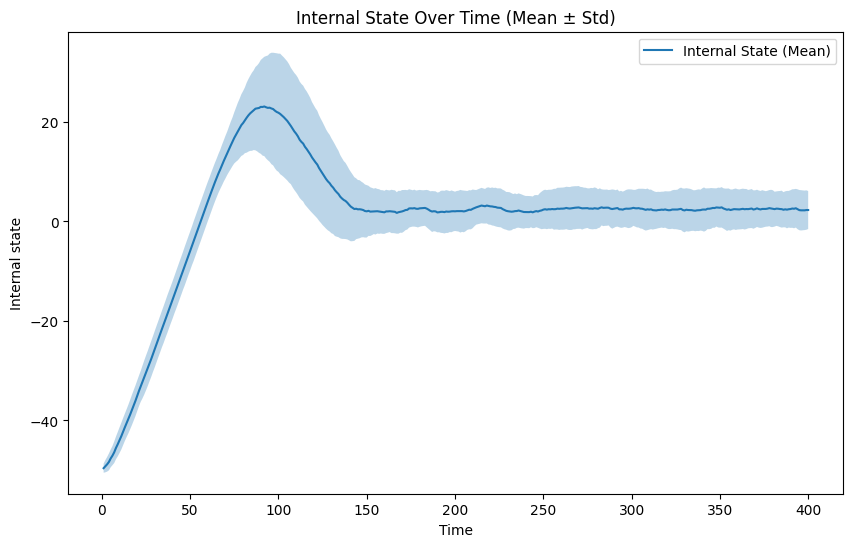

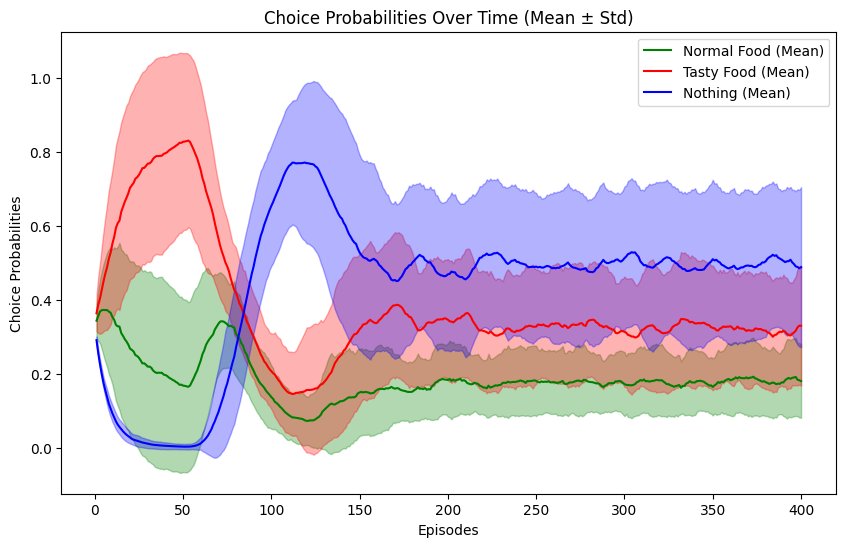

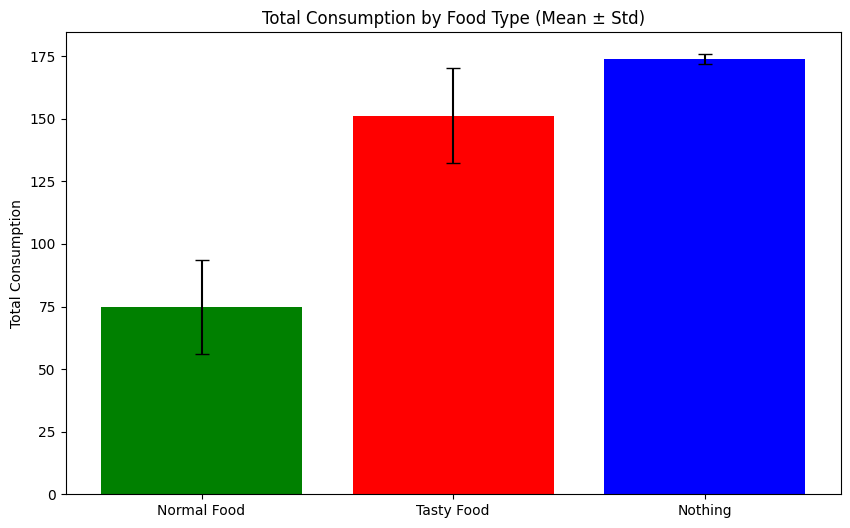

In [106]:
time = np.arange(1, nb_steps + 1)

# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, internal_states_mean, label="Internal State (Mean)")
plt.fill_between(time, internal_states_mean - internal_states_std, internal_states_mean + internal_states_std, alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Internal state")
plt.title("Internal State Over Time (Mean ± Std)")
plt.legend()
plt.show()

# Graphique des probabilités de choix
plt.figure(figsize=(10, 6))
plt.plot(time, choice_probabilities_mean[0], label="Normal Food (Mean)", color="green")
plt.fill_between(time, 
                 choice_probabilities_mean[0] - choice_probabilities_std[0], 
                 choice_probabilities_mean[0] + choice_probabilities_std[0], 
                 color="green", alpha=0.3)

plt.plot(time, choice_probabilities_mean[1], label="Tasty Food (Mean)", color="red")
plt.fill_between(time, 
                 choice_probabilities_mean[1] - choice_probabilities_std[1], 
                 choice_probabilities_mean[1] + choice_probabilities_std[1], 
                 color="red", alpha=0.3)

plt.plot(time, choice_probabilities_mean[2], label="Nothing (Mean)", color="blue")
plt.fill_between(time, 
                 choice_probabilities_mean[2] - choice_probabilities_std[2], 
                 choice_probabilities_mean[2] + choice_probabilities_std[2], 
                 color="blue", alpha=0.3)

plt.xlabel("Episodes")
plt.ylabel("Choice Probabilities")
plt.title("Choice Probabilities Over Time (Mean ± Std)")
plt.legend()
plt.show()

# Calcul des consommations totales
total_consumption_normal = np.sum(choices_history_all == 0, axis=1).mean()
total_consumption_tasty = np.sum(choices_history_all == 1, axis=1).mean()
total_consumption_nothing = np.sum(choices_history_all == 2, axis=1).mean()

std_consumption_normal = np.sum(choices_history_all == 0, axis=1).std()
std_consumption_tasty = np.sum(choices_history_all == 1, axis=1).std()
std_consumption_nothing = np.sum(choices_history_all == 2, axis=1).std()

# Graphique des consommations totales
plt.figure(figsize=(10, 6))
bars = plt.bar(["Normal Food", "Tasty Food", "Nothing"], 
               [total_consumption_normal, total_consumption_tasty, total_consumption_nothing], 
               yerr=[std_consumption_normal, std_consumption_tasty, std_consumption_nothing], 
               color=["green", "red", "blue"], capsize=5)

plt.ylabel("Total Consumption")
plt.title("Total Consumption by Food Type (Mean ± Std)")
plt.show()

## Groupe 2 : choix entre nourriture normale et rien 

In [157]:
# Configuration de l'environnement
initial_energy = [-50]  # État interne initial
setpoints = [0]  # Point optimal d'énergie
weights = [1.0]  # Poids de l'état
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
normal_food_reward = 2  # Récompense pour nourriture normale
palatability_bonus = 0.5  # T (Bonus pour nourriture hyperpalatable)
energy_cost = 1

env = HyperpalatableEnvironment(
    H=initial_energy,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    palatability_bonus=palatability_bonus,
    normal_food_reward=normal_food_reward,
    energy_cost = energy_cost,
)

In [158]:
env.set_no_tasty_food()

state_size = 1  # Discrétisation des états
action_size = 2  # Deux actions possibles : nourriture normale ou hyperpalatable
q_table = {
    0: np.zeros(2),  # 2 actions : nourriture normale ou ne rien faire 
}
agent = QLearning(state_size, action_size, alpha=0.25, gamma=0.8, beta=50, q_table=q_table)

In [159]:
# Paramètres
nb_agents = 100
nb_steps = 400

# Initialisation des structures de données pour tous les agents
reward_history_all_group2 = np.zeros((nb_agents, nb_steps))
choices_history_all_group2 = np.zeros((nb_agents, nb_steps), dtype=int)
internal_states_all_group2 = np.zeros((nb_agents, nb_steps))

all_nb_normal_choices = []

for agent_idx in range(nb_agents):
    state = env.reset()
    total_reward = 0

    agent.reset()
    nb_normal_choices=0

    for step in range(nb_steps):
        # Choisir une action pour l'état unique
        action = agent.choose_action(state, evaluation=True)

        # Effectuer une étape dans l'environnement
        next_state, reward, done, _ = env.step(action)

        # Mise à jour de la Q-table
        agent.update_q_value(state, action, reward, state)

        # Stockage des données
        reward_history_all_group2[agent_idx, step] = reward
        internal_states_all_group2[agent_idx, step] = env.state[0]
        if action == 0:
            nb_normal_choices+=1 

    all_nb_normal_choices.append(nb_normal_choices)

    print(f"agent : {agent_idx}, mean reward : {np.mean(reward_history_all[agent_idx])}")

# Calcul des moyennes et écarts types
reward_mean_group2 = np.mean(reward_history_all_group2, axis=0)
reward_std_group2 = np.std(reward_history_all_group2, axis=0)

internal_states_mean_group2 = np.mean(internal_states_all_group2, axis=0)
internal_states_std_group2 = np.std(internal_states_all_group2, axis=0)


agent : 0, mean reward : 2.3382207560539245
agent : 1, mean reward : 2.0061815977096558
agent : 2, mean reward : 2.4014663100242615
agent : 3, mean reward : 2.4043720042705536
agent : 4, mean reward : 2.4043720042705536
agent : 5, mean reward : 2.4014663100242615
agent : 6, mean reward : 2.4014663100242615
agent : 7, mean reward : 2.4043720042705536
agent : 8, mean reward : 2.4064663100242614
agent : 9, mean reward : 2.3885606157779695
agent : 10, mean reward : 1.9845588207244873
agent : 11, mean reward : 2.3906549215316772
agent : 12, mean reward : 2.366937838792801
agent : 13, mean reward : 2.387749227285385
agent : 14, mean reward : 2.3777492272853853
agent : 15, mean reward : 2.4043720042705536
agent : 16, mean reward : 2.382749227285385
agent : 17, mean reward : 2.3611264503002167
agent : 18, mean reward : 2.4064663100242614
agent : 19, mean reward : 2.3885606157779695
agent : 20, mean reward : 2.4014663100242615
agent : 21, mean reward : 2.3985606157779693
agent : 22, mean reward

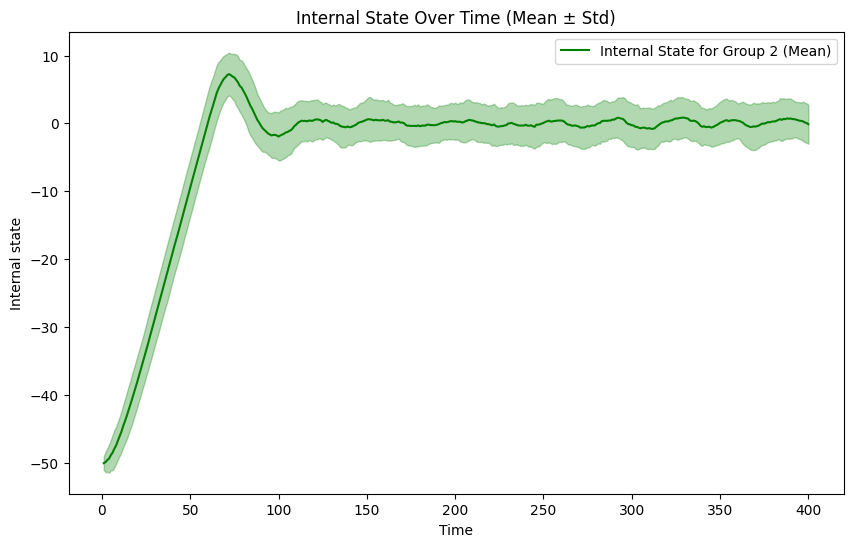

In [160]:
time = np.arange(1, nb_steps + 1)

# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, internal_states_mean_group2, label="Internal State for Group 2 (Mean)",color="green")
plt.fill_between(time, internal_states_mean_group2 - internal_states_std_group2, internal_states_mean_group2 + internal_states_std_group2, alpha=0.3,color="green")
plt.xlabel("Time")
plt.ylabel("Internal state")
plt.title("Internal State Over Time (Mean ± Std)")
plt.legend()
plt.show()

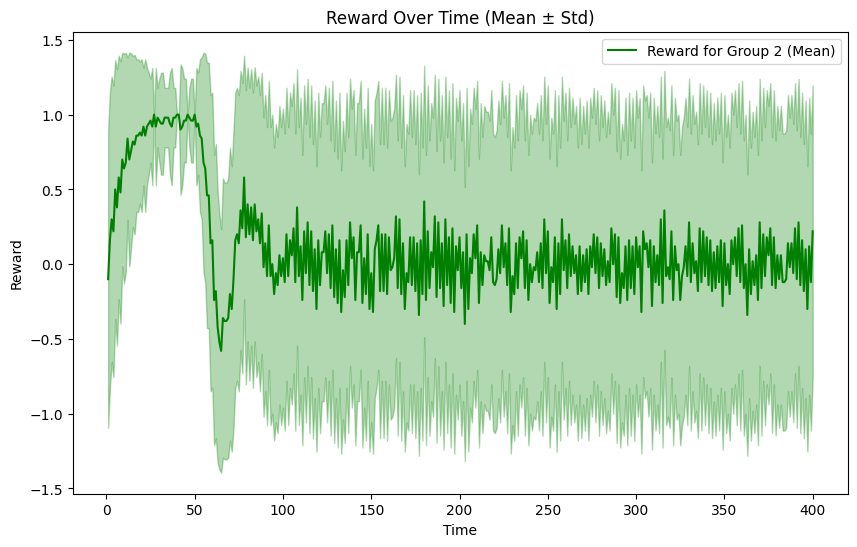

In [161]:
time = np.arange(1, nb_steps + 1)

# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, reward_mean_group2, label="Reward for Group 2 (Mean)",color="green")
plt.fill_between(time, reward_mean_group2 - reward_std_group2, reward_mean_group2 + reward_std_group2, alpha=0.3,color="green")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.title("Reward Over Time (Mean ± Std)")
plt.legend()
plt.show()

## Groupe 3 : choix entre nourriture hyperpalpable et rien 

In [162]:
env.set_no_tasty_food(False)
env.set_no_normal_food(True)

state_size = 1  # Discrétisation des états
action_size = 2  # Deux actions possibles : nourriture normale ou hyperpalatable
q_table = {
    0: np.zeros(2),  # 2 actions : nourriture normale ou ne rien faire 
}
agent = QLearning(state_size, action_size, alpha=0.25, gamma=0.8, beta=50, q_table=q_table)

In [ ]:
# Paramètres
nb_agents = 100
nb_steps = 400

# Initialisation des structures de données pour tous les agents
reward_history_all_group3 = np.zeros((nb_agents, nb_steps))
choices_history_all_group3 = np.zeros((nb_agents, nb_steps), dtype=int)
internal_states_all_group3 = np.zeros((nb_agents, nb_steps))

all_nb_tasty_choices = []

for agent_idx in range(nb_agents):
    state = env.reset()
    total_reward = 0

    agent.reset()
    nb_tasty_choices=0

    for step in range(nb_steps):
        # Choisir une action pour l'état unique
        action = agent.choose_action(state, evaluation=True)

        # Effectuer une étape dans l'environnement
        next_state, reward, done, _ = env.step(action)

        # Mise à jour de la Q-table
        agent.update_q_value(state, action, reward, state)

        # Stockage des données
        reward_history_all_group3[agent_idx, step] = reward
        internal_states_all_group3[agent_idx, step] = env.state[0]
        if action == 0:
            nb_tasty_choices+=1 

    all_nb_tasty_choices.append(nb_tasty_choices)

    print(f"agent : {agent_idx}, mean reward : {np.mean(reward_history_all[agent_idx])}")

# Calcul des moyennes et écarts types
reward_mean_group3 = np.mean(reward_history_all_group3, axis=0)
reward_std_group3 = np.std(reward_history_all_group3, axis=0)

internal_states_mean_group3 = np.mean(internal_states_all_group3, axis=0)
internal_states_std_group3 = np.std(internal_states_all_group3, axis=0)


agent : 0, mean reward : 2.3382207560539245
agent : 1, mean reward : 2.0061815977096558
agent : 2, mean reward : 2.4014663100242615
agent : 3, mean reward : 2.4043720042705536
agent : 4, mean reward : 2.4043720042705536
agent : 5, mean reward : 2.4014663100242615
agent : 6, mean reward : 2.4014663100242615
agent : 7, mean reward : 2.4043720042705536
agent : 8, mean reward : 2.4064663100242614
agent : 9, mean reward : 2.3885606157779695
agent : 10, mean reward : 1.9845588207244873
agent : 11, mean reward : 2.3906549215316772
agent : 12, mean reward : 2.366937838792801
agent : 13, mean reward : 2.387749227285385
agent : 14, mean reward : 2.3777492272853853
agent : 15, mean reward : 2.4043720042705536
agent : 16, mean reward : 2.382749227285385
agent : 17, mean reward : 2.3611264503002167
agent : 18, mean reward : 2.4064663100242614
agent : 19, mean reward : 2.3885606157779695
agent : 20, mean reward : 2.4014663100242615
agent : 21, mean reward : 2.3985606157779693
agent : 22, mean reward

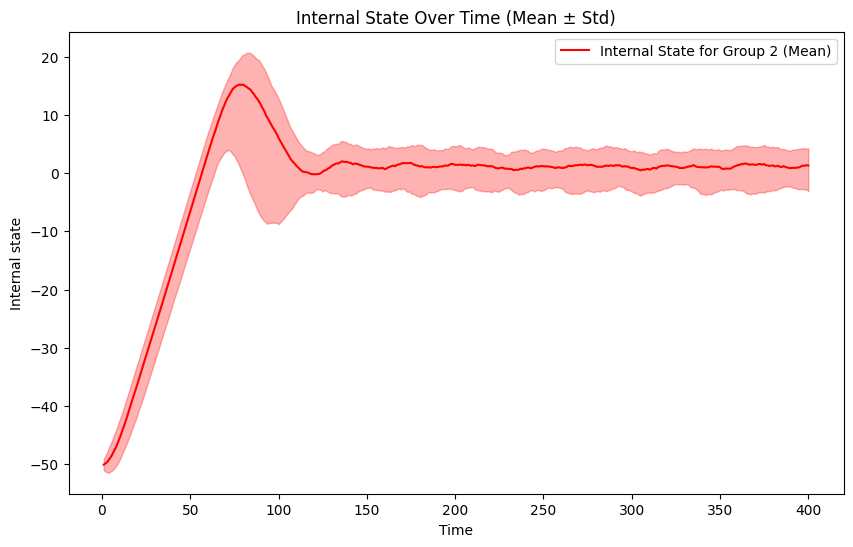

In [164]:
time = np.arange(1, nb_steps + 1)

# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, internal_states_mean_group3, label="Internal State for Group 2 (Mean)",color="red")
plt.fill_between(time, internal_states_mean_group2 - internal_states_std_group3, internal_states_mean_group3 + internal_states_std_group3, alpha=0.3,color="red")
plt.xlabel("Time")
plt.ylabel("Internal state")
plt.title("Internal State Over Time (Mean ± Std)")
plt.legend()
plt.show()

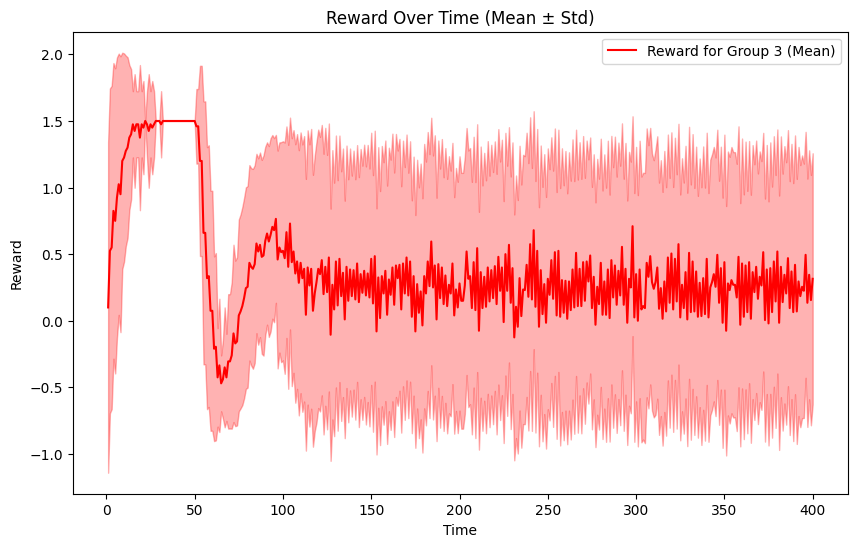

In [165]:
time = np.arange(1, nb_steps + 1)

# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, reward_mean_group3, label="Reward for Group 3 (Mean)",color="red")
plt.fill_between(time, reward_mean_group3 - reward_std_group3, reward_mean_group3 + reward_std_group3, alpha=0.3,color="red")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.title("Reward Over Time (Mean ± Std)")
plt.legend()
plt.show()

### Comparaison des choix de nourriture normal pour le groupe 2 VS nourriture hyperpalpable pour le groupe 3

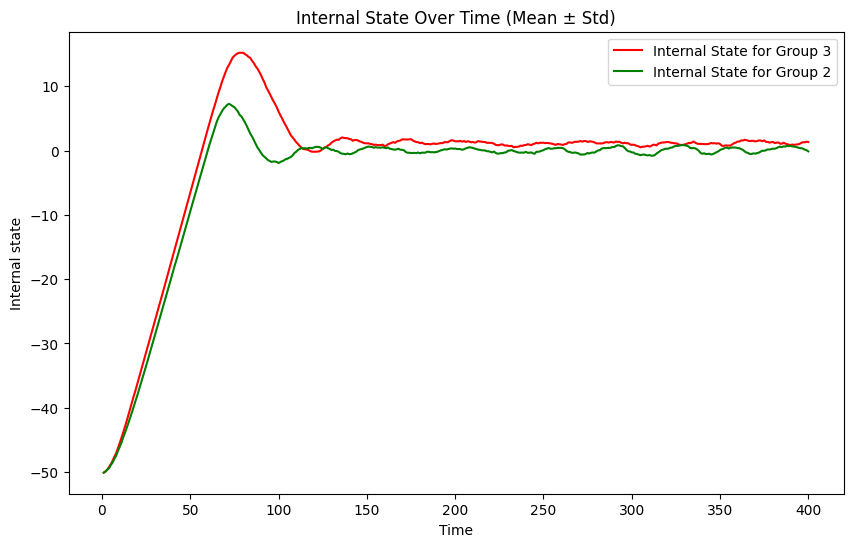

In [166]:
# Graphique de l'état interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, internal_states_mean_group3, label="Internal State for Group 3",color="red")
plt.plot(time, internal_states_mean_group2, label="Internal State for Group 2",color="green")
plt.xlabel("Time")
plt.ylabel("Internal state")
plt.title("Internal State Over Time (Mean ± Std)")
plt.legend()
plt.show()

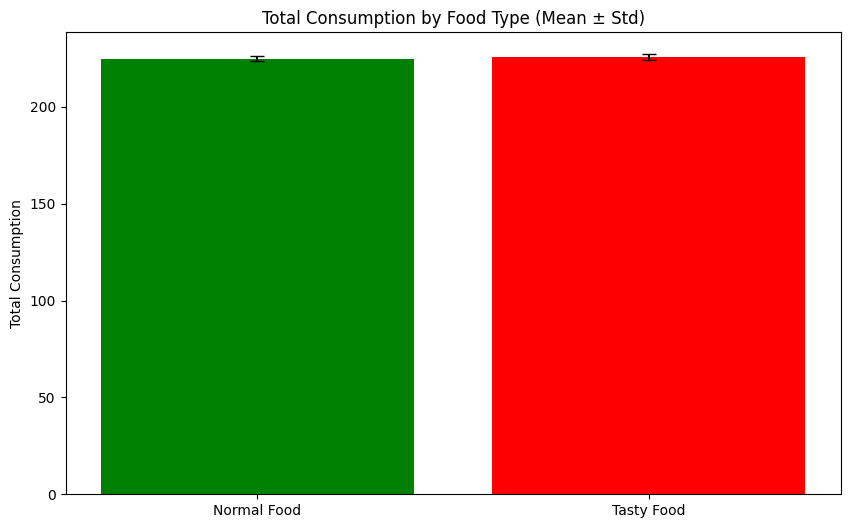

In [167]:
plt.figure(figsize=(10, 6))
bars = plt.bar(["Normal Food", "Tasty Food"], 
               [np.mean(all_nb_normal_choices,axis=0), np.mean(all_nb_tasty_choices,axis=0)], 
               yerr=[np.std(all_nb_normal_choices,axis=0), np.std(all_nb_tasty_choices,axis=0)], 
               color=["green", "red"], capsize=5)

plt.ylabel("Total Consumption")
plt.title("Total Consumption by Food Type (Mean ± Std)")
plt.show()

# Etude de l'impact de T

In [116]:
# Différentes valeurs de T
T_values = np.logspace(-2, 0.5, num=25)
#T_values = [0.01, 0.1, 0.5, 1.0, 2.0]  


# Paramètres généraux
nb_agents = 100
nb_steps = 400

# Structures pour stocker les résultats pour chaque T
results = {}

for T in T_values:
    print(f"Training agents with T = {T}")
    
    # Configuration de l'environnement pour chaque T
    initial_energy = [-50]  # État interne initial
    setpoints = [0]  # Point optimal d'énergie
    weights = [1.0]  # Poids de l'état
    exponents = [2, 2]  # Non-linéarité du drive
    effects = {}  # Placeholder pour les effets
    normal_food_reward = 2  # Récompense pour nourriture normale
    palatability_bonus = T  # T (Bonus pour nourriture hyperpalatable)
    energy_cost = 1  # Coût énergétique

    env = HyperpalatableEnvironment(
        H=initial_energy,
        setpoints=setpoints,
        weights=weights,
        exponents=exponents,
        effects=effects,
        palatability_bonus=palatability_bonus,
        normal_food_reward=normal_food_reward,
        energy_cost=energy_cost,
    )

    # Configuration de l'agent Q-learning
    state_size = 1
    action_size = 3
    q_table = {0: np.zeros(action_size)}

    agent = QLearning(state_size, action_size, alpha=0.25, gamma=0.8, beta=50, q_table=q_table)

    # Initialisation des structures de données pour tous les agents
    reward_history_all = np.zeros((nb_agents, nb_steps))
    choice_probabilities_all = {0: np.zeros((nb_agents, nb_steps)),
                                1: np.zeros((nb_agents, nb_steps))}
    choices_history_all = np.zeros((nb_agents, nb_steps), dtype=int)
    internal_states_all = np.zeros((nb_agents, nb_steps))

    # Boucle d'entraînement pour chaque agent
    for agent_idx in range(nb_agents):
        state = env.reset()
        agent.reset()
        total_reward = 0

        for step in range(nb_steps):
            # Choisir une action pour l'état unique
            action = agent.choose_action(state, evaluation=True)

            # Effectuer une étape dans l'environnement
            next_state, reward, done, _ = env.step(action)

            # Mise à jour de la Q-table
            agent.update_q_value(state, action, reward, state)

            # Stockage des données
            reward_history_all[agent_idx, step] = reward
            q_table_softmax = torch.nn.functional.softmax(torch.tensor(agent.q_table[0]), dim=0)
            choice_probabilities_all[0][agent_idx, step] = q_table_softmax[0].item()
            choice_probabilities_all[1][agent_idx, step] = q_table_softmax[1].item()
            choices_history_all[agent_idx, step] = action
            internal_states_all[agent_idx, step] = env.state[0]

        print(f"Agent {agent_idx + 1}/{nb_agents}, Mean Reward: {np.mean(reward_history_all[agent_idx])}, Mean internal state : {np.mean(internal_states_all[agent_idx])}")

    # Calcul des moyennes et écarts types pour analyse
    reward_mean = np.mean(reward_history_all, axis=0)
    internal_states_mean = np.mean(internal_states_all, axis=0)
    normal_food_count = np.sum(choices_history_all == 0, axis=1)
    tasty_food_count = np.sum(choices_history_all == 1, axis=1)

    # Stockage des résultats pour cette valeur de T
    results[T] = {
        "reward_mean": np.mean(reward_mean),
        "internal_states_mean": np.mean(internal_states_mean),
        "total_normal_food": np.mean(normal_food_count),
        "total_tasty_food": np.mean(tasty_food_count),
    }

Training agents with T = 0.01
Agent 1/100, Mean Reward: 0.1277249974012375, Mean internal state : -1.68
Agent 2/100, Mean Reward: 0.11732499778270722, Mean internal state : -0.685
Agent 3/100, Mean Reward: 0.12272499740123749, Mean internal state : -2.545
Agent 4/100, Mean Reward: 0.12744999766349793, Mean internal state : -1.02
Agent 5/100, Mean Reward: 0.11847499668598176, Mean internal state : -2.555
Agent 6/100, Mean Reward: 0.12274999737739563, Mean internal state : -0.45
Agent 7/100, Mean Reward: 0.12359999656677247, Mean internal state : -2.165
Agent 8/100, Mean Reward: 0.1228499972820282, Mean internal state : -1.725
Agent 9/100, Mean Reward: 0.10759999752044677, Mean internal state : -1.765
Agent 10/100, Mean Reward: 0.11697499811649323, Mean internal state : -2.41
Agent 11/100, Mean Reward: 0.12234999775886536, Mean internal state : -1.92
Agent 12/100, Mean Reward: 0.08772499740123749, Mean internal state : -1.77
Agent 13/100, Mean Reward: 0.11264999747276307, Mean internal s

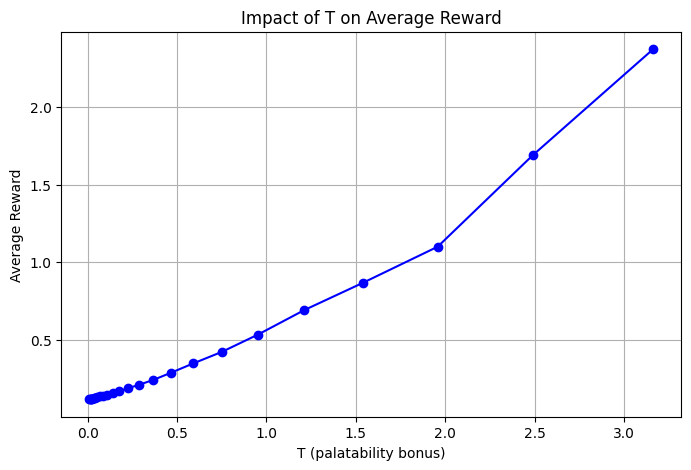

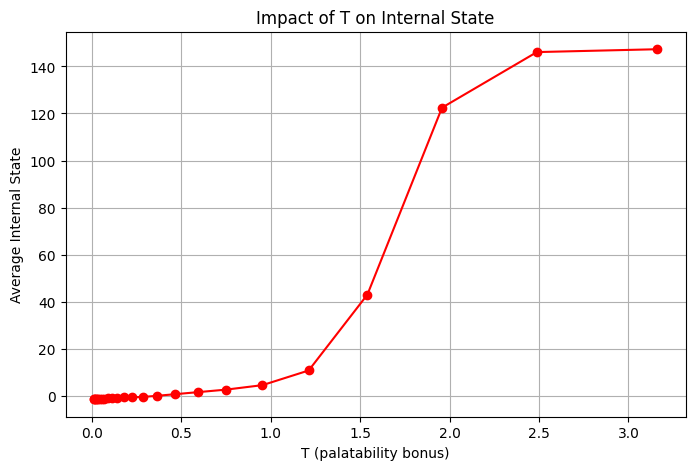

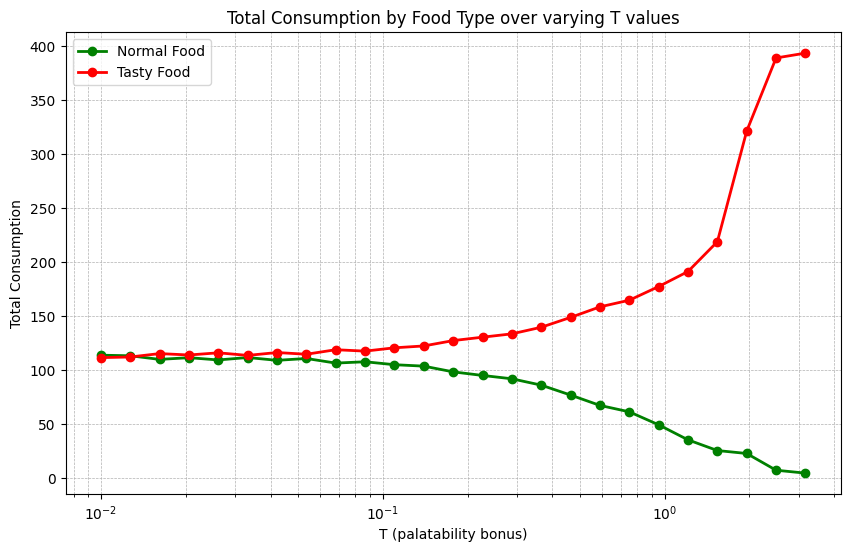

In [117]:
# Visualisation des résultats en fonction de T

T_list = list(results.keys())
reward_means = [results[T]["reward_mean"] for T in T_list]
internal_states_means = [results[T]["internal_states_mean"] for T in T_list]
total_normal_foods = [results[T]["total_normal_food"] for T in T_list]
total_tasty_foods = [results[T]["total_tasty_food"] for T in T_list]

# Plot 1: Récompense moyenne en fonction de T
plt.figure(figsize=(8, 5))
plt.plot(T_list, reward_means, marker='o', linestyle='-', color='blue')
plt.xlabel("T (palatability bonus)")
plt.ylabel("Average Reward")
plt.title("Impact of T on Average Reward")
plt.grid()
plt.show()

# Plot 2: État interne moyen en fonction de T
plt.figure(figsize=(8, 5))
plt.plot(T_list, internal_states_means, marker='o', linestyle='-', color='red')
plt.xlabel("T (palatability bonus)")
plt.ylabel("Average Internal State")
plt.title("Impact of T on Internal State")
plt.grid()
plt.show()

# Plot 3: Total Consumption by Food Type
# Tracé des courbes de consommation totale par type d'aliment en fonction de T
plt.figure(figsize=(10, 6))
plt.plot(T_values, total_normal_foods, label="Normal Food", color='green', linewidth=2, marker='o')
plt.plot(T_values, total_tasty_foods, label="Tasty Food", color='red', linewidth=2, marker='o')

# Mise en forme du graphique
plt.xscale('log')  # Utilisation d'une échelle logarithmique pour mieux visualiser l'effet de T
plt.xlabel("T (palatability bonus)")
plt.ylabel("Total Consumption")
plt.title("Total Consumption by Food Type over varying T values")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()